## Data Set Information:

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). 

Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

### Original dataset from: https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
import time
import os
import zipfile
import random

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

# for this project sklearn is used
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# some models to test from basic to more elaborate
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
# hyperparameter search
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# random state
SEED = 20 

## Extract and laod Datasets

In [2]:
# extract and load dataset
DATASET_ZIP = 'Datasets/Students_Grades/student.zip'
DATASET_TARGET = 'student_grades'

def extract_dataset(source_dir=DATASET_ZIP, target_dir=DATASET_TARGET):
    # takes zip folder and unzips to target destination
    try:
        with zipfile.ZipFile(DATASET_ZIP,'r') as zip_ref:
            zip_ref.extractall(DATASET_TARGET)
    except IOError:
        print('rror: File does not appear to exist.')

def load_dataset(source_dir, dataset_name, sep=','):
    # loads csv data into pandas DataFrame
    csv_path = os.path.join(source_dir, dataset_name)
    return pd.read_csv(csv_path, sep)

# get possible themes from matplotlib cmap_d
themes = sorted(plt.cm.cmap_d)

In [3]:
# extract zip file
extract_dataset(DATASET_ZIP, DATASET_TARGET)
# load datasets into pandas
math_grades = load_dataset(source_dir='student_grades', dataset_name='student-mat.csv', sep=';')
por_grades = load_dataset(source_dir='student_grades', dataset_name='student-por.csv', sep=';')
# concatenate dataframes for both topics
student_grades = pd.concat([math_grades, por_grades])

In [4]:
math_grades.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:

<ol>
<li>school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)</li>  
<li>sex - student's sex (binary: 'F' - female or 'M' - male)</li>
<li>age - student's age (numeric: from 15 to 22)</li>
<li>address - student's home address type (binary: 'U' - urban or 'R' - rural)</li>
<li>famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)</li>
<li>Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)</li>
<li>Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)</li>
<li>Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)</li>
<li>Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')</li>
<li>Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')</li>
<li>reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')</li>
<li>guardian - student's guardian (nominal: 'mother', 'father' or 'other')</li>
<li>traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)</li>
<li>studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)</li>
<li>failures - number of past class failures (numeric: n if 1<=n<3, else 4)</li>
<li>schoolsup - extra educational support (binary: yes or no)</li>
<li>famsup - family educational support (binary: yes or no)</li>
<li>paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)</li>
<li>activities - extra-curricular activities (binary: yes or no)</li>
<li>nursery - attended nursery school (binary: yes or no)</li>
<li>higher - wants to take higher education (binary: yes or no)</li>
<li>internet - Internet access at home (binary: yes or no)</li>
<li>romantic - with a romantic relationship (binary: yes or no)</li>
<li>famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)</li>
<li>freetime - free time after school (numeric: from 1 - very low to 5 - very high)</li>
<li>goout - going out with friends (numeric: from 1 - very low to 5 - very high)</li>
<li>Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)</li>
<li>Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)</li>
<li>health - current health status (numeric: from 1 - very bad to 5 - very good)</li>
<li>absences - number of school absences (numeric: from 0 to 93)</li>
</ol>

# These grades are related with the course subject, Math or Portuguese:

<ul>
<li>31. G1 - first period grade (numeric: from 0 to 20)</li>
<li>31. G2 - second period grade (numeric: from 0 to 20)</li>
<li>32. G3 - final grade (numeric: from 0 to 20, output target)</li>
</ul>

In [5]:
# takeing a look at the datatypes
student_grades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 33 columns):
school        1044 non-null object
sex           1044 non-null object
age           1044 non-null int64
address       1044 non-null object
famsize       1044 non-null object
Pstatus       1044 non-null object
Medu          1044 non-null int64
Fedu          1044 non-null int64
Mjob          1044 non-null object
Fjob          1044 non-null object
reason        1044 non-null object
guardian      1044 non-null object
traveltime    1044 non-null int64
studytime     1044 non-null int64
failures      1044 non-null int64
schoolsup     1044 non-null object
famsup        1044 non-null object
paid          1044 non-null object
activities    1044 non-null object
nursery       1044 non-null object
higher        1044 non-null object
internet      1044 non-null object
romantic      1044 non-null object
famrel        1044 non-null int64
freetime      1044 non-null int64
goout         1044 non-null

In [6]:
student_grades.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## Data Exploration

In [7]:
# create a copy of the original dataset for data exploration
explore_grades = student_grades.copy()

# create grade avg column (could be helpful)
explore_grades['grade_avg'] = (explore_grades['G1'] +
                                 explore_grades['G2'] +
                                 explore_grades['G3'])/3

explore_grades['grade_avg_G12'] = (explore_grades['G1'] +
                                     explore_grades['G2'])/2


## Grades Distribution

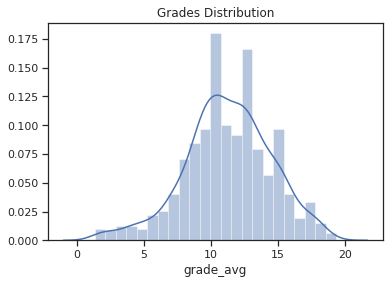

In [8]:
# grades are Gaussian distributed
sns.distplot(explore_grades['grade_avg']);
plt.title('Grades Distribution');

## School
#### school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)

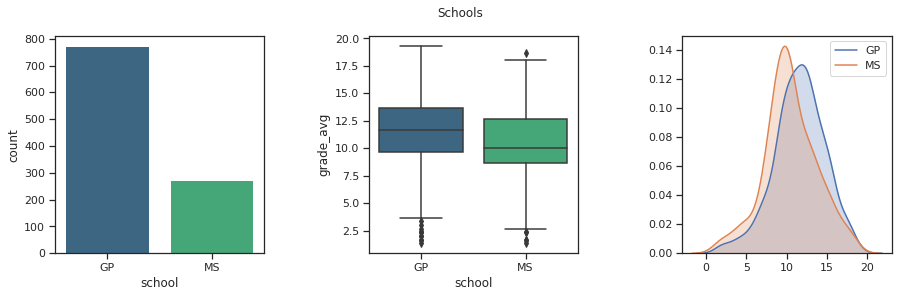

In [9]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Schools')

sns.countplot(explore_grades['school'], palette='viridis',ax=axs[0]);
sns.boxplot(x='school', y='grade_avg', data=explore_grades, palette='viridis', ax=axs[1]);

for school in (['GP', 'MS']):
    sns.kdeplot(explore_grades[(explore_grades['school']==school)]['grade_avg'],
                label=school, shade=True, ax=axs[2]);


### Age

Most students are around the age of 16 to 17 (age histogram slight right skew), according to the following graphs they tend to score a bit worse as they grow older.

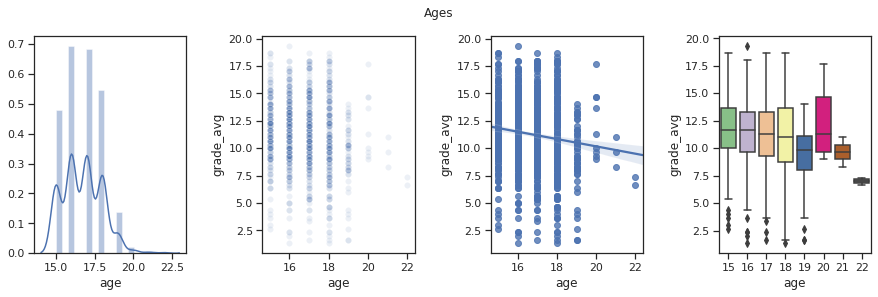

In [10]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Ages')

# age histogram, slight right skew
sns.distplot(explore_grades['age'], ax=axs[0]);
sns.scatterplot(x='age', y='grade_avg', data=explore_grades, palette='Accent', alpha=0.1, ax=axs[1]);
sns.regplot(x='age', y='grade_avg', data=explore_grades, ax=axs[2]);
sns.boxplot(x='age', y='grade_avg', data=explore_grades, palette='Accent', ax=axs[3]);


## Gender

Males tend to score slightly higher on math class on average but females in portuguese class.

# Females:591
# Males:453


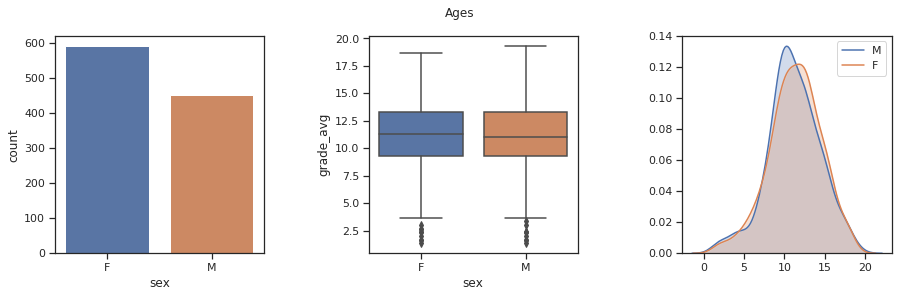

In [11]:
males = len(explore_grades[(explore_grades['sex']=='M')])
females = len(explore_grades[(explore_grades['sex']=='F')])

print(f'# Females:{females}\n# Males:{males}')

# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Ages')

# males tend to score slightly higher on math class on avg.
sns.countplot(explore_grades['sex'], ax=axs[0]);
sns.boxplot(x ='sex', y ='grade_avg', data = explore_grades, ax=axs[1]);

for sex in (['M', 'F']):
    sns.kdeplot(explore_grades[(explore_grades['sex']==sex)]['grade_avg'], label=sex, shade=True, ax=axs[2]);

## Address
Students comming from Urban areas tend to score  slightly higher on average but does not appear to be relevant.

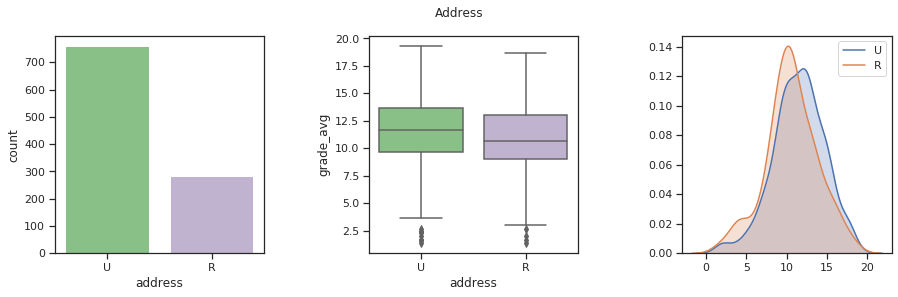

In [12]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Address')

# students from Urban areas tend to score  slightly higher on average
sns.countplot(explore_grades['address'], palette='Accent', ax=axs[0]);
sns.boxplot(x='address', y='grade_avg', data=explore_grades, palette='Accent', ax=axs[1]);

for adrs in (['U', 'R']):
    sns.kdeplot(explore_grades[(explore_grades['address']==adrs)]['grade_avg'],
                label=adrs, shade=True, ax=axs[2]);

## Family Size

Student with less than 3 members might score better, but does not seem relevant. 

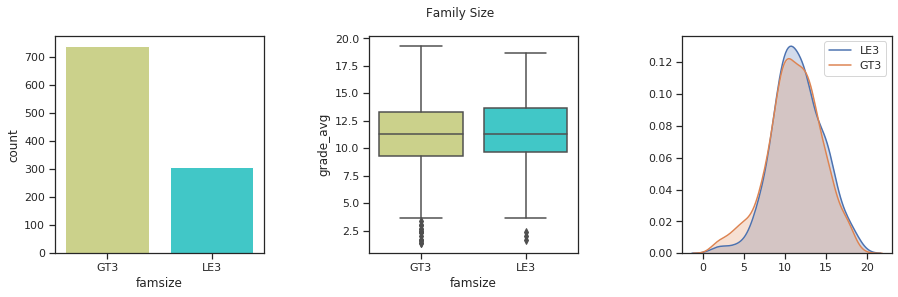

In [13]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Family Size')

# plots
sns.countplot(explore_grades['famsize'], palette='rainbow_r', ax=axs[0]);
sns.boxplot(x='famsize', y='grade_avg', data=explore_grades, palette='rainbow_r', ax=axs[1]);

for famsize in (['LE3', 'GT3']):
    sns.kdeplot(explore_grades[(explore_grades['famsize']==famsize)]['grade_avg'],
                label=famsize, shade=True, ax=axs[2]);

## Parent Marital Status

Parents living apart is unrepresented and contraty to own beliefs it does not seem to have any interesting effect on the student performance.

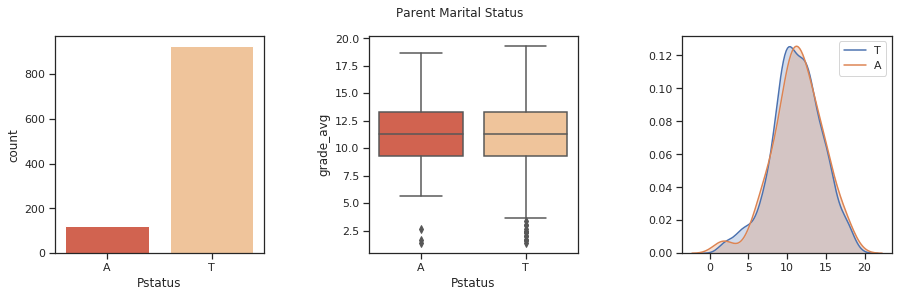

In [14]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Parent Marital Status')

# plots
sns.countplot(explore_grades['Pstatus'], palette='OrRd_r', ax=axs[0]);
sns.boxplot(x='Pstatus', y='grade_avg', data=explore_grades, palette='OrRd_r', ax=axs[1]);

for pstatus in (['T', 'A']):
    sns.kdeplot(explore_grades[(explore_grades['Pstatus']==pstatus)]['grade_avg'],
                label=pstatus, shade=True, ax=axs[2]);

## Study Time

Students who put more time into study tend to get slightly better grades. However, there does not seem to be many students actually studying much... or even beyond 4 hours a week.

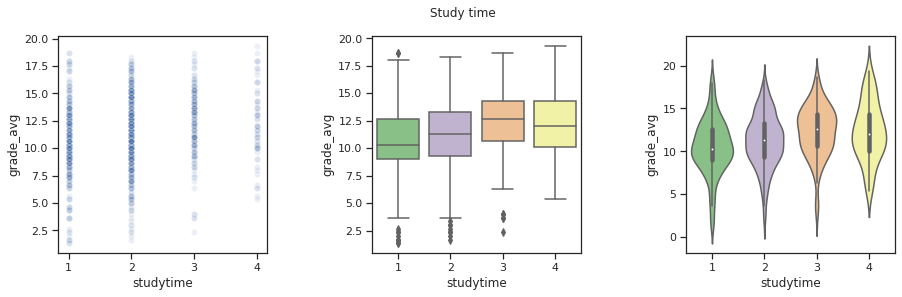

In [15]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Study time')

# there is a slight trend upwards
sns.scatterplot(x='studytime', y='grade_avg', data=explore_grades, palette='Accent', alpha=0.1, ax=axs[0]);
sns.boxplot(x='studytime', y='grade_avg', data=explore_grades, palette='Accent', ax=axs[1]);
sns.violinplot(x='studytime', y='grade_avg', data=explore_grades, palette='Accent', ax=axs[2]);

## Parents Education
<ul>
<li>Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2:5th to 9th grade, 3:secondary education or 4:higher education</li>
<li>Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2:5th to 9th grade, 3:secondary education or 4:higher education)</li>
</ul>

As paretns have more education, the students tend to score higher.

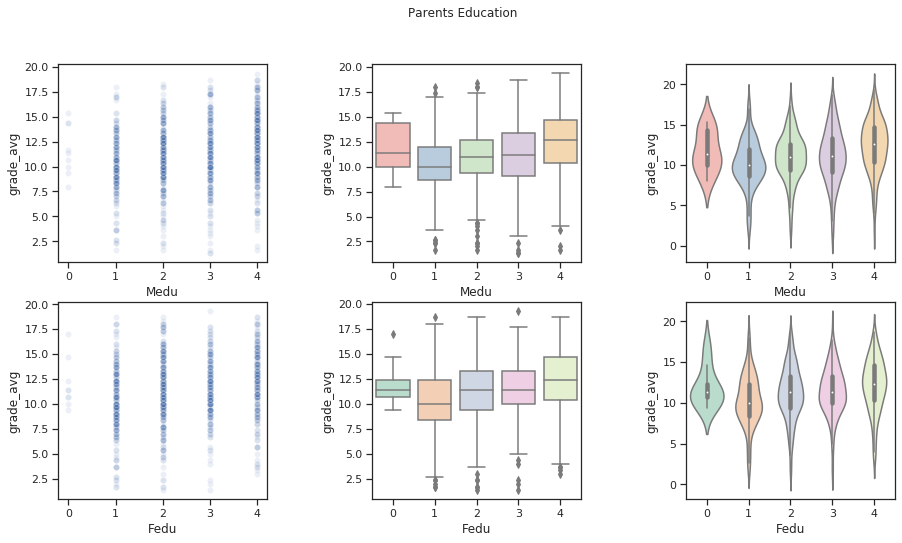

In [16]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Parents Education')

# mother education, there is a slight trend upwards
sns.scatterplot(x='Medu', y='grade_avg', data=explore_grades, alpha=0.1, ax=axs[0][0]);
sns.boxplot(x='Medu', y='grade_avg', data=explore_grades, palette='Pastel1', ax=axs[0][1]);
sns.violinplot(x='Medu', y='grade_avg', data=explore_grades, palette='Pastel1', ax=axs[0][2]);

# father education, there is a slight trend upwards
sns.scatterplot(x='Fedu', y='grade_avg', data=explore_grades, alpha=0.1, ax=axs[1][0]);
sns.boxplot(x='Fedu', y='grade_avg', data=explore_grades, palette='Pastel2', ax=axs[1][1]);
sns.violinplot(x='Fedu', y='grade_avg', data=explore_grades, palette='Pastel2', ax=axs[1][2]);

### Parents job

Most parents fall into the "other", however stundents having a teacher father or mother tend to score better.

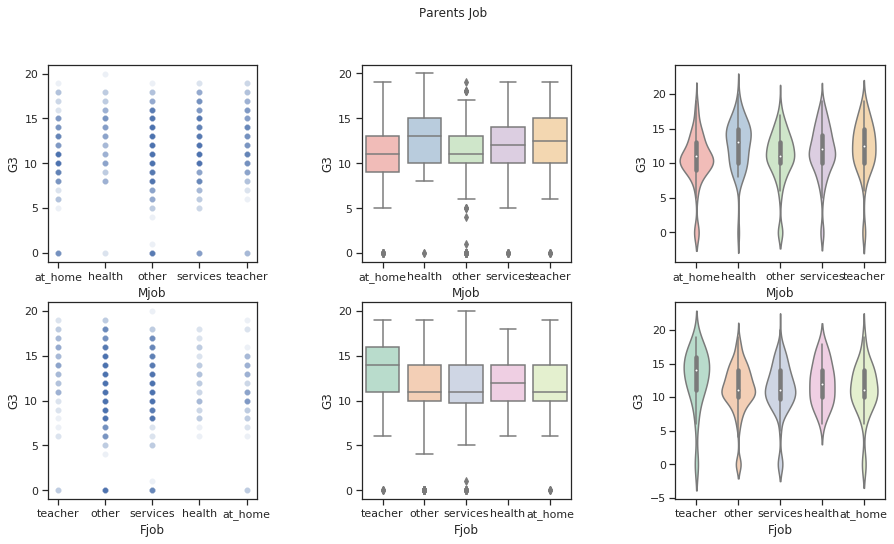

In [17]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Parents Job')

# mother job
sns.scatterplot(x='Mjob', y='G3', data=explore_grades, alpha=0.1, ax=axs[0][0]);
sns.boxplot(x='Mjob', y='G3', data=explore_grades, palette='Pastel1', ax=axs[0][1]);
sns.violinplot(x='Mjob', y='G3', data=explore_grades, palette='Pastel1', ax=axs[0][2]);

# father job
sns.scatterplot(x='Fjob', y='G3', data=explore_grades, alpha=0.1, ax=axs[1][0]);
sns.boxplot(x='Fjob', y='G3', data=explore_grades, palette='Pastel2', ax=axs[1][1]);
sns.violinplot(x='Fjob', y='G3', data=explore_grades, palette='Pastel2', ax=axs[1][2]);

### Reason to study

<ul>
<li>reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')</li>
</ul>

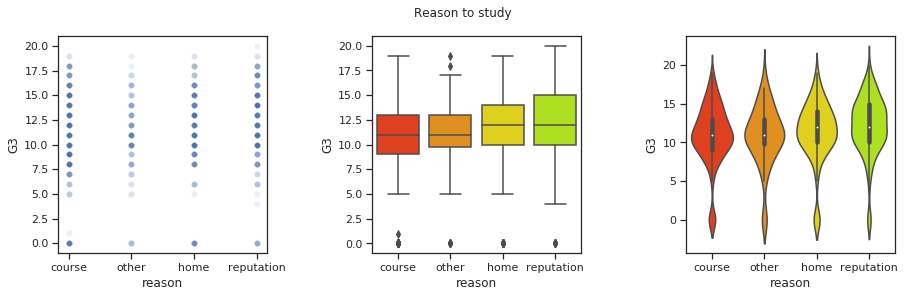

In [18]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Reason to study')

# mother job
sns.scatterplot(x='reason', y='G3', data=explore_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='reason', y='G3', data=explore_grades, palette='prism', ax=axs[1]);
sns.violinplot(x='reason', y='G3', data=explore_grades, palette='prism', ax=axs[2]);

### Guardian

<ul>
<li>guardian - student's guardian (nominal: 'mother', 'father' or 'other')</li>
</ul>

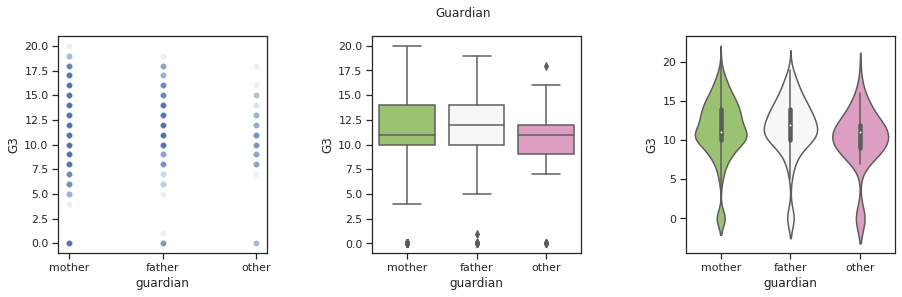

In [19]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Guardian')

# mother job
sns.scatterplot(x='guardian', y='G3', data=explore_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='guardian', y='G3', data=explore_grades, palette='PiYG_r', ax=axs[1]);
sns.violinplot(x='guardian', y='G3', data=explore_grades, palette='PiYG_r', ax=axs[2]);

### Travel Time

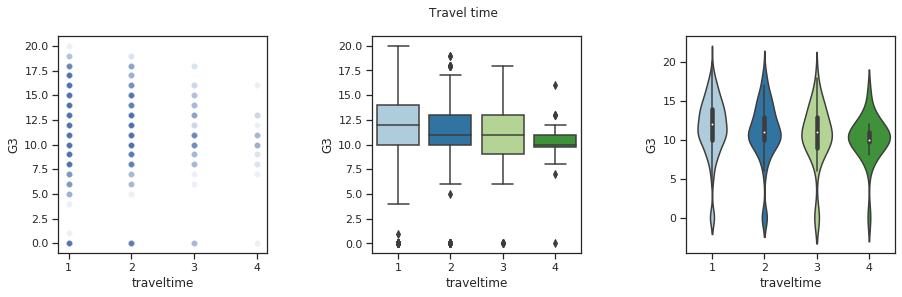

In [20]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Travel time')

# mother job
sns.scatterplot(x='traveltime', y='G3', data=explore_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='traveltime', y='G3', data=explore_grades, palette='Paired', ax=axs[1]);
sns.violinplot(x='traveltime', y='G3', data=explore_grades, palette='Paired', ax=axs[2]);

### Failures

Clear trend downwards

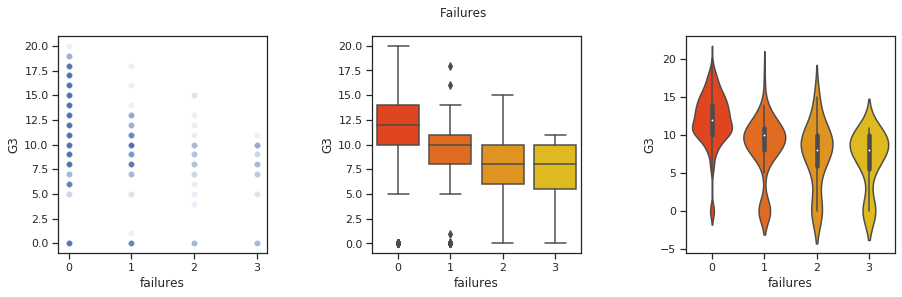

In [21]:
# create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Failures')

# mother job
sns.scatterplot(x='failures', y='G3', data=explore_grades, alpha=0.1, ax=axs[0]);
sns.boxplot(x='failures', y='G3', data=explore_grades, palette='autumn', ax=axs[1]);
sns.violinplot(x='failures', y='G3', data=explore_grades, palette='autumn', ax=axs[2]);

### Binary Features
<b>extra education</b>: schoolsup - extra educational support (binary: yes or no)<br>
<b>family educational support</b> - (binary: yes or no)<br>
<b>paid</b> - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)<br>
<b>activities</b> - extra-curricular activities (binary: yes or no)<br>
<b>nursery</b> - attended nursery school (binary: yes or no)<br>
<b>higher</b> - wants to take higher education (binary: yes or no)<br>
<b>internet</b> - Internet access at home (binary: yes or no)<br>
<b>romantic</b> - with a romantic relationship (binary: yes or no)<br>

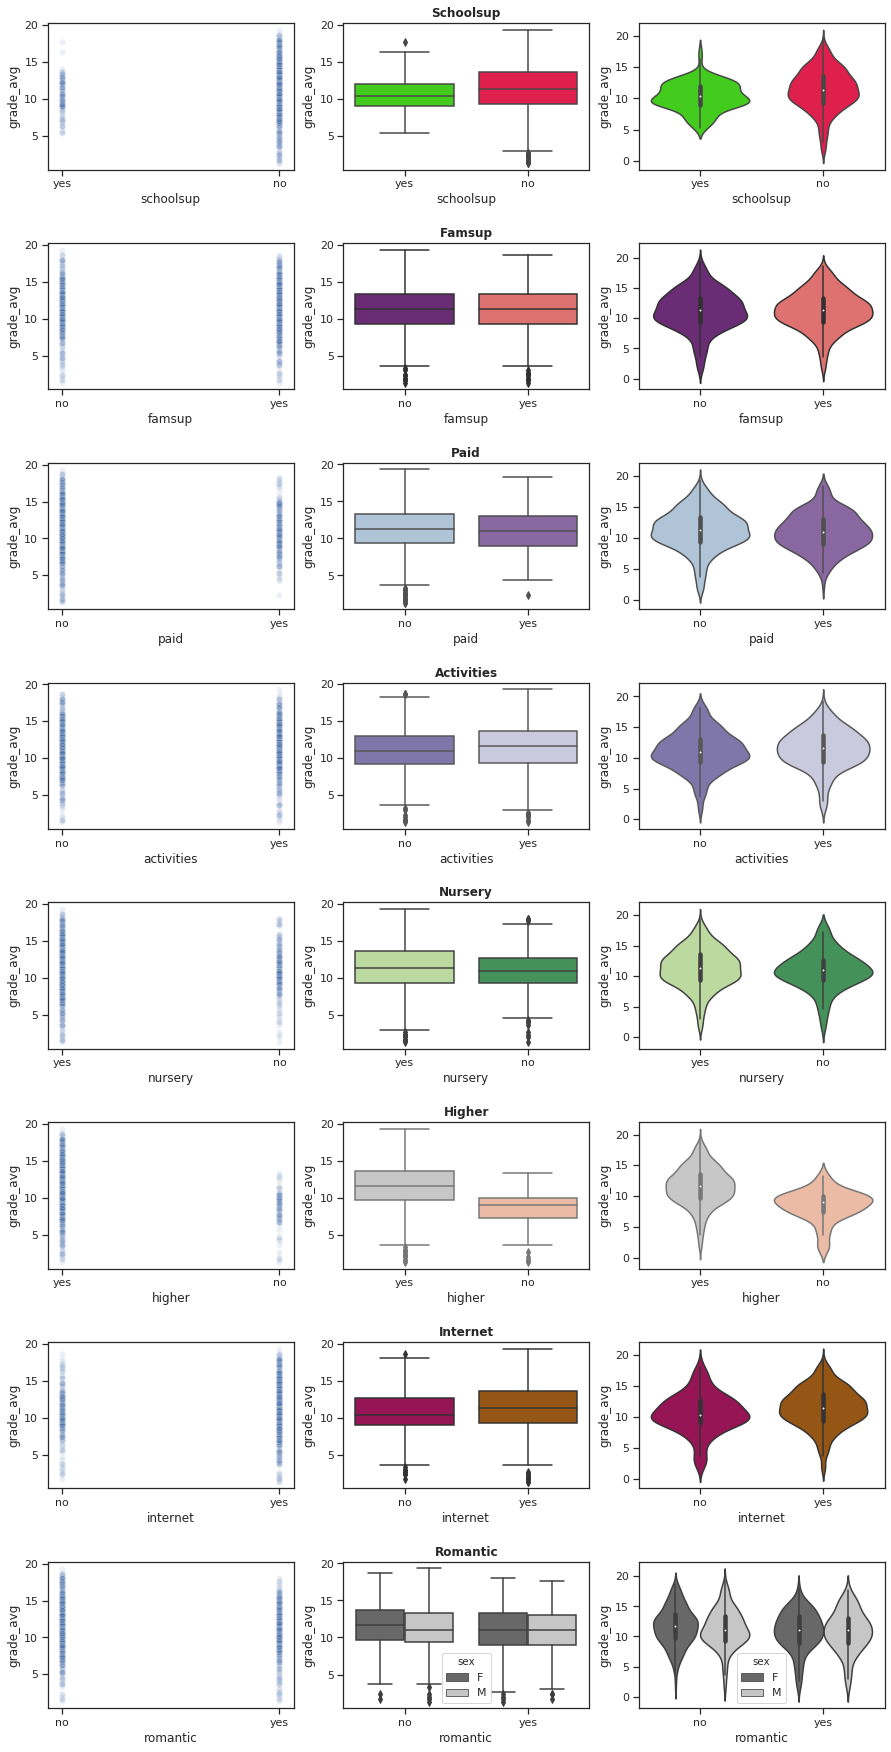

In [22]:
# list of binary features
features_to_plot = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
rows = len(features_to_plot)

# create subplots
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(15, 31))
fig.subplots_adjust(wspace=0.2, hspace=0.5)

def plot_binary_feature(x_feature='x', y='grade_avg', data=explore_grades, row=0, theme='Blues', hue=None):
    axs[row][1].set_title(x_feature.title(),  weight='bold')
    sns.scatterplot(x=x_feature, y='grade_avg', data=explore_grades, alpha=0.1, ax=axs[row][0]);
    sns.boxplot(x=x_feature, y='grade_avg', data=explore_grades, palette=theme, hue=hue, ax=axs[row][1]);
    sns.violinplot(x=x_feature, y='grade_avg', data=explore_grades, palette=theme, hue=hue, ax=axs[row][2]);

for row, x in enumerate(features_to_plot):
    hue=None
    if x == 'romantic':
        hue='sex'

    random_theme = random.choice(themes)
    plot_binary_feature(x_feature=x, row=row, theme=random_theme, hue=hue)


####  From 1 - very bad to 5 excellent

<ol>
<li>famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)</li>
<li>freetime - free time after school (numeric: from 1 - very low to 5 - very high)</li>
<li>goout - going out with friends (numeric: from 1 - very low to 5 - very high)</li>
<li>Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)</li>
<li>Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)</li>
<li>health - current health status (numeric: from 1 - very bad to 5 - very good)</li>
</ol>


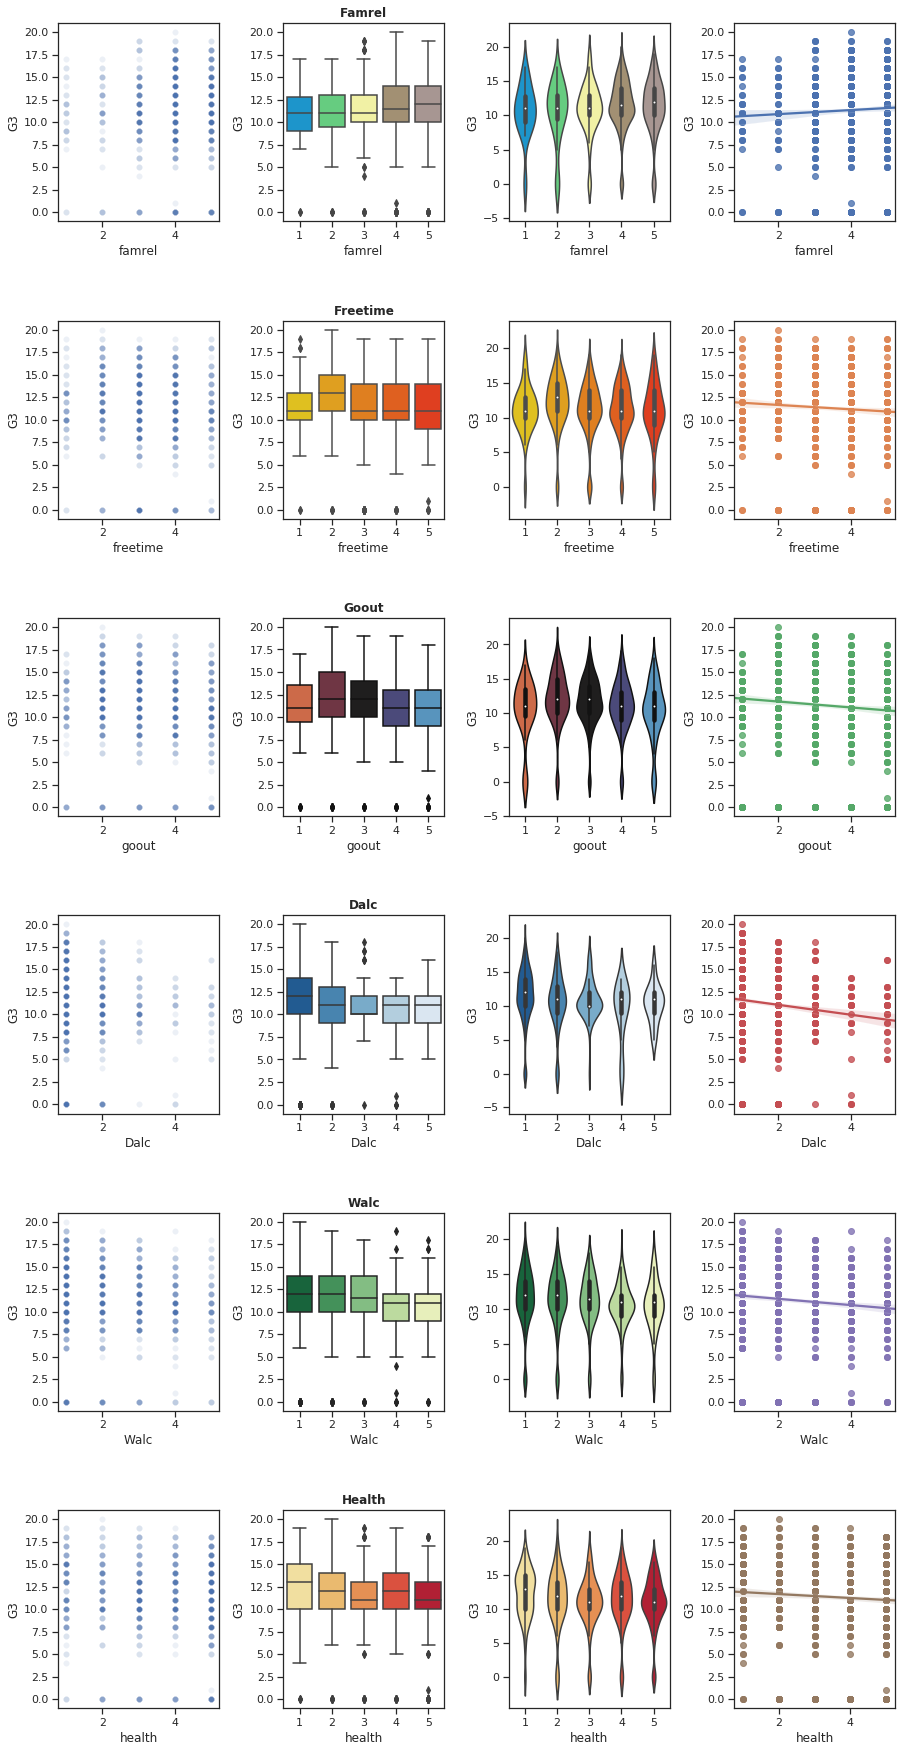

In [23]:
# list of binary features
features_to_plot = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
rows = len(features_to_plot)

# create subplots
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(15, 31))
fig.subplots_adjust(wspace=0.4, hspace=0.5)

def plot_binary_feature(x_feature='x', y='G3', data=explore_grades, row=0, theme='Blues'):
    axs[row][1].set_title(x_feature.title(),  weight='bold')
    sns.scatterplot(x=x_feature, y=y, data=explore_grades, alpha=0.1, ax=axs[row][0]);
    sns.boxplot(x=x_feature, y=y, data=explore_grades, palette=theme, ax=axs[row][1]);
    sns.violinplot(x=x_feature, y=y, data=explore_grades, palette=theme, ax=axs[row][2]);
    sns.regplot(x=x_feature, y=y, data=explore_grades, ax=axs[row][3]);

for row, x in enumerate(features_to_plot):
    random_theme = random.choice(themes)
    plot_binary_feature(x_feature=x, row=row, theme=random_theme)

### Absences - number of school absences (numeric: from 0 to 93)

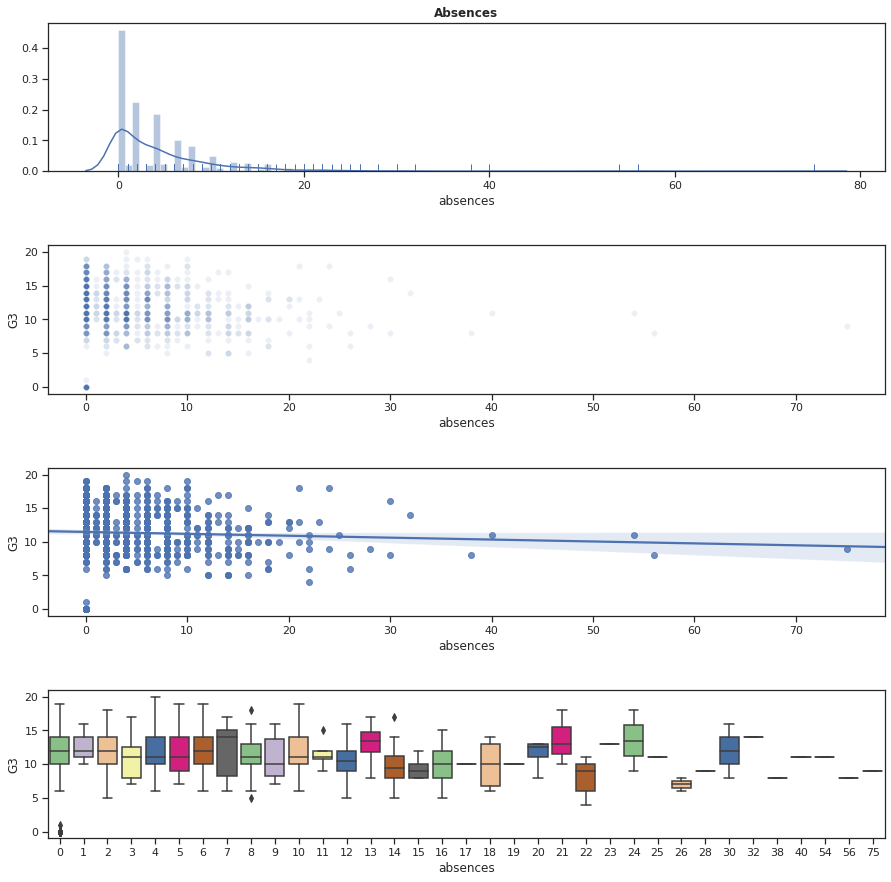

In [24]:
# create subplots to save some space
fig, axs = plt.subplots(nrows=4, figsize=(15, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axs[0].set_title('Absences',  weight='bold')

# age histogram, slight right skew
sns.distplot(explore_grades['absences'], bins=100, rug=True, ax=axs[0]);
sns.scatterplot(x='absences', y='G3', data=explore_grades, palette='Accent', alpha=0.1, ax=axs[1]);
sns.regplot(x='absences', y='G3', data=explore_grades, ax=axs[2]);
sns.boxplot(x='absences', y='G3', data=explore_grades, palette='Accent', ax=axs[3]);


### Some Feature Engineering

Based on what we can see from the previous plots, we can do some feature combinations hoping to get a better resutls. 

Note to self: this step is something we always want to try to do, a good feature engineering can outperform the best algorithms.

In [25]:
# hard working index, this is a feature we can create based on how many hours a student spends working
# on the number of failures, number of absences, etc.
# the bias is that the lower the number is the better the grade will be.

# create a non study time
student_grades['non_studytime'] = (10 - student_grades[['studytime']])
# create hard working index based on these features combined
student_grades['hard_working_index'] = student_grades[['non_studytime',
                                                       'freetime',
                                                       'failures',
                                                       'absences',
                                                       'goout',
                                                       'Walc',
                                                      ]].sum(axis=1)


# create grade avg column (could be helpful)
student_grades['grade_avg'] = (student_grades['G1'] +
                                 student_grades['G2'] +
                                 student_grades['G3'])/3

student_grades['grade_avg_G12'] = (student_grades['G1'] +
                                     student_grades['G2'])/2



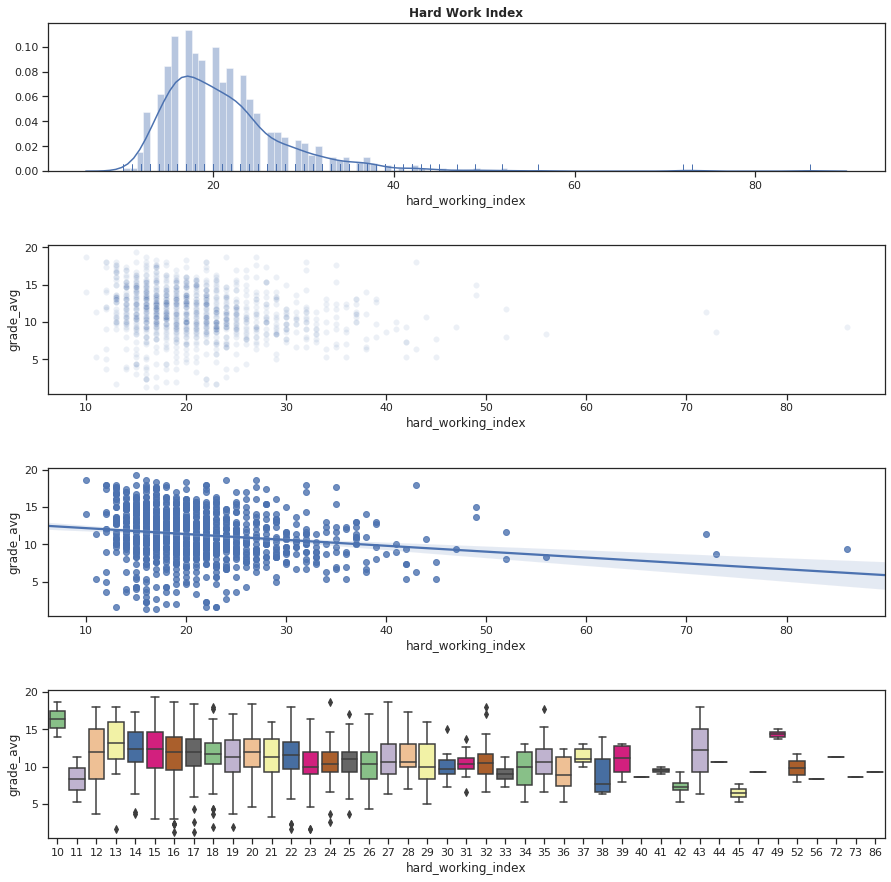

In [26]:
# create subplots to save some space
fig, axs = plt.subplots(nrows=4, figsize=(15, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axs[0].set_title('Hard Work Index',  weight='bold')

# age histogram, slight right skew
sns.distplot(student_grades['hard_working_index'], bins=100, rug=True, ax=axs[0]);
sns.scatterplot(x='hard_working_index', y='grade_avg', data=student_grades, palette='Accent', alpha=0.1, ax=axs[1]);
sns.regplot(x='hard_working_index', y='grade_avg', data=student_grades, ax=axs[2]);
sns.boxplot(x='hard_working_index', y='grade_avg', data=student_grades, palette='Accent', ax=axs[3]);


# Training predictions models

Looking for any missing values before preparing a test/train split, fortunately there are none.

In [27]:
# looking for null values, there is no null vales
print('Null values:', student_grades.isnull().values.any())

Null values: False


In [28]:
# preparing train/test split (80%-20%) and setting random seed for consistency
train_set, test_set = train_test_split(student_grades, test_size=0.2, random_state=SEED)

# get training labels
y_train = train_set['G3']
x_train = train_set.drop('G3', axis=1)

# get test labels
y_test = test_set['G3']
x_test = test_set.drop('G3', axis=1)

### Converting categorical features to one-hot-encoding and ordinal encoding using pipeline

reference for more transformers
https://scikit-learn.org/stable/data_transforms.html

In [29]:
# list of binary features
binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
                   'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# list of categorical features to be one-hot-encoded (label binarized)
catego_features = ['Mjob', 'Fjob', 'reason', 'guardian']

# list of numerical features
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
                      'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'hard_working_index']

# list of numerical features
#numerical_features = ['age', 'Medu', 'Fedu', 'traveltime',
#                      'famrel', 'freetime', 'Dalc', 'Walc', 'health', 'G1', 'G2', 'hard_working_index']


# build a pipeline to do transformations
pipeline = ColumnTransformer([
    # transforms labels to numbers
    ('binary_pipeline', OrdinalEncoder(), binary_features),
    # a dense matrix should be fine since there are not many posible values a catego feature can take
    ('catego_pipeline', OneHotEncoder(sparse=False), catego_features),
    # in case there is a null value fill with median
    ('numerical_pipeline', SimpleImputer(strategy='median'), numerical_features),
])

# apply pipeline to dataframe
x_train = pipeline.fit_transform(x_train)
x_test = pipeline.fit_transform(x_test)

In [30]:
# random regression forest 
#forest = RandomForestRegressor(random_state=SEED, n_estimators=10)
#forest.fit(x_train, y_train)

# get predictions
#y_hat = forest.predict(x_train)

# get mean sqared error on training set
#print(np.sqrt(mean_squared_error(y_train, y_hat)))


In [31]:
# fit a linear regresion model as a baseline
# using a 10 fold cross validation
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

scores = cross_val_score(lin_reg, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print('Cross-Validation avg. RMSE score:',np.mean(rmse_scores))

Cross-Validation avg. RMSE score: 1.5073736490498781


In [32]:
# fit a Ridge regresion model
# using a 10 fold cross validation
rig_reg = Ridge(solver='sag', alpha=0.5, random_state=SEED)
rig_reg.fit(x_train, y_train)

scores = cross_val_score(rig_reg, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print('Cross-Validation avg. RMSE score:',np.mean(rmse_scores))

Cross-Validation avg. RMSE score: 1.4918259376138887


In [33]:
# fit a Lasso regresion model
# using a 10 fold cross validation
lasso_reg = Ridge(random_state=SEED)
lasso_reg.fit(x_train, y_train)

scores = cross_val_score(lasso_reg, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print('Cross-Validation avg. RMSE score:',np.mean(rmse_scores))

Cross-Validation avg. RMSE score: 1.506365384825068


In [34]:
#import warnings
#warnings.filterwarnings('ignore')

# KNN will not be good in this case but just for fun...
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

scores = cross_val_score(knn, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print('Cross-Validation avg. RMSE score:',np.mean(rmse_scores))


Cross-Validation avg. RMSE score: 2.4728175349911146


In [35]:
# Decision tree model
tree = DecisionTreeRegressor(random_state=SEED)
tree.fit(x_train, y_train)

scores = cross_val_score(tree, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print('Cross-Validation avg. RMSE score:',np.mean(rmse_scores))

Cross-Validation avg. RMSE score: 2.151757413777935


In [36]:
# random regression forest 
forest = RandomForestRegressor(n_estimators=10, random_state=SEED)
forest.fit(x_train, y_train)

scores = cross_val_score(forest, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print('Cross-Validation avg. RMSE score:',np.mean(rmse_scores))

Cross-Validation avg. RMSE score: 1.4799916810178884


Ridge Regression and Regression Forest score the best, next a hyper parameter selection for Regression Forest is carried out to check if we can get a better score than the default parameters.

### Hyper parameters Search for Regression Forest

In [37]:
# random search trying to find better hyper parameters than defaults
param_distributions = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=32),
    }

rnd_search = RandomizedSearchCV(RandomForestRegressor(random_state=SEED),
                                param_distributions=param_distributions,
                                n_iter=100,
                                cv=10,
                                scoring='neg_mean_squared_error',
                                random_state=SEED,
                                iid=False)

rnd_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [38]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2.0868419663787514 {'max_features': 4, 'n_estimators': 91}
1.4677389572083939 {'max_features': 16, 'n_estimators': 96}
1.4467574221278519 {'max_features': 29, 'n_estimators': 91}
1.595259997588706 {'max_features': 10, 'n_estimators': 21}
1.6110604877685422 {'max_features': 12, 'n_estimators': 23}
1.7202626489902677 {'max_features': 8, 'n_estimators': 35}
2.750402430019878 {'max_features': 1, 'n_estimators': 41}
1.4419217295419953 {'max_features': 22, 'n_estimators': 91}
1.4350434884563577 {'max_features': 27, 'n_estimators': 84}
1.476063105789991 {'max_features': 17, 'n_estimators': 63}
1.5909264396121312 {'max_features': 17, 'n_estimators': 8}
1.8493310768021038 {'max_features': 6, 'n_estimators': 99}
1.808160809924466 {'max_features': 7, 'n_estimators': 27}
1.5104811133399891 {'max_features': 14, 'n_estimators': 76}
1.4517289903222346 {'max_features': 27, 'n_estimators': 26}
2.086617843633037 {'max_features': 4, 'n_estimators': 75}
1.5684200130921677 {'max_features': 12, 'n_estimator

#### In general  high number of trees and a high max_features  get a better result than the defaults in this case

In [39]:
# get the model with the best set of hyperparameters for regression forest
best_model = rnd_search.best_estimator_
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=26, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=95,
                      n_jobs=None, oob_score=False, random_state=20, verbose=0,
                      warm_start=False)

In [40]:
best_train_pred = best_model.predict(x_train)

In [41]:
# get mean sqared error on training set
rmse = np.sqrt(mean_squared_error(y_train, best_train_pred))
print('Train RMSE:', rmse)

Train RMSE: 0.530749804205929


In [42]:
# some training predictions examples:
for idx in range(20, 30):
    print(f'Training prediction: {best_train_pred[idx]:.2f} - Actual grade: {y_train.iat[idx]}')

Training prediction: 17.78 - Actual grade: 18
Training prediction: 9.21 - Actual grade: 9
Training prediction: 9.95 - Actual grade: 10
Training prediction: 14.51 - Actual grade: 15
Training prediction: 17.15 - Actual grade: 17
Training prediction: 9.96 - Actual grade: 10
Training prediction: 6.26 - Actual grade: 6
Training prediction: 10.05 - Actual grade: 10
Training prediction: 16.07 - Actual grade: 16
Training prediction: 9.96 - Actual grade: 10


### Testing the model on the test set

In [43]:
test_predictions = best_model.predict(x_test)

In [44]:
# get mean sqared error on training set
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print('Test RMSE:', rmse)

# get ROUNDED mean sqared error on training set
rmse = np.sqrt(mean_squared_error(y_test, [int(round(i)) for i in test_predictions]))
print('Rounded test RMSE:', rmse)

Test RMSE: 1.8745489353633686
Rounded test RMSE: 1.885477107642778


Some example predictions, since grades are integers and not floats we need to round the result to the nearest decimal, this does not seem to affect the RMSE error.

In [45]:
# some examples from test set
for idx in range(20, 30):
    print(f'Test prediction: {test_predictions[idx]:.2f} - Actual grade: {y_test.iat[idx]}')
    print(f'Round prediction: {int(round(test_predictions[idx]))} - Actual grade: {y_test.iat[idx]}\n')

Test prediction: 12.08 - Actual grade: 12
Round prediction: 12 - Actual grade: 12

Test prediction: 11.01 - Actual grade: 11
Round prediction: 11 - Actual grade: 11

Test prediction: 14.55 - Actual grade: 15
Round prediction: 15 - Actual grade: 15

Test prediction: 8.43 - Actual grade: 9
Round prediction: 8 - Actual grade: 9

Test prediction: 16.62 - Actual grade: 16
Round prediction: 17 - Actual grade: 16

Test prediction: 10.57 - Actual grade: 11
Round prediction: 11 - Actual grade: 11

Test prediction: 14.47 - Actual grade: 15
Round prediction: 14 - Actual grade: 15

Test prediction: 10.62 - Actual grade: 12
Round prediction: 11 - Actual grade: 12

Test prediction: 15.80 - Actual grade: 16
Round prediction: 16 - Actual grade: 16

Test prediction: 14.91 - Actual grade: 16
Round prediction: 15 - Actual grade: 16

